# compartment-related analyses


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import bioframe
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.colors as colors
import cooler
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import os
import glob
import pairtools
import random
import bbi
import cooltools
import multiprocess as mp

import cooltools.eigdecomp
import cooltools.expected
import cooltools.saddle
import cooler

In [2]:
#naming 
pathDir = "/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers"

conditions = [
    '1',
    '2'
]

short_names = {
    '1':'ND-dmso',
    '2':'4OHT-dmso'
}


long_names = {
    '1' : 'JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1',
    '2' : 'JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1'    
}


coolerfile = {}
for cond in conditions:
    coolerfile[cond] = '{}/{}.mm10.nodups.65M.1000.mcool::resolutions/250000'.format(pathDir, long_names[cond])
    
clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}
binsize = 250000
resolution=binsize


In [3]:
coolerfile


{'1': '/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::resolutions/250000',
 '2': '/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::resolutions/250000'}

# calling compartments

In [6]:
#Computing expected in cis/trans-check 100000
for cond in conditions:
    mcoolfile = coolerfile[cond]
    expectedfile = '{}/{}.mm10.250000.cis.expected'.format(pathDir, long_names[cond])
    !bsub -q short -W 04:00 -n 4 -R "span[hosts=1]" -R "select[rh=8]" -R rusage[mem=24000] \
        "source activate coolerenv_manual_master; cooltools compute-expected -p 4 -t cis $mcoolfile -o $expectedfile"

INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549057> is submitted to queue <short>.
INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549058> is submitted to queue <short>.


In [7]:
#make binned genome
chromsizes = '/nl/umw_job_dekker/cshare/reference/sorted_chromsizes/mm10.reduced.chrom.sizes'
mm10bins = '/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/mm10bins_250000'

!bsub -q short -W 04:00 -n 4 -R "span[hosts=1]" -R "select[rh=8]" -R rusage[mem=24000] \
        "source activate coolerenv_manual_master; cooler makebins -o $mm10bins $chromsizes 250000"

INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549059> is submitted to queue <short>.


In [8]:
#make gene_coverage track ... delete header
mm10bins = '/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/mm10bins_250000'
genecovfile = '/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/genecov_mm10_250000'

!bsub -q short -W 04:00 -n 4 -R "span[hosts=1]" -R "select[rh=8]" -R rusage[mem=24000] \
        "source activate coolerenv_manual_master; cooltools genome genecov $mm10bins mm10 > $genecovfile"

INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549061> is submitted to queue <short>.


In [14]:
for cond in conditions:
    mcoolfile = coolerfile[cond]
    compcallfile = '{}/{}.mm10.250000.compcall'.format(pathDir, long_names[cond])
    referencetrack = '/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/genecov_mm10_250000'
    
    !bsub -q short -W 04:00 -n 4 -R "span[hosts=1]" -R "select[rh=8]" -R rusage[mem=24000] \
    "source activate coolerenv_manual_master; cooltools call-compartments --reference-track $referencetrack --contact-type cis -o $compcallfile --bigwig $mcoolfile"
   

INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549066> is submitted to queue <short>.
INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549067> is submitted to queue <short>.


# saddleplots and relative compartment strength

/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib

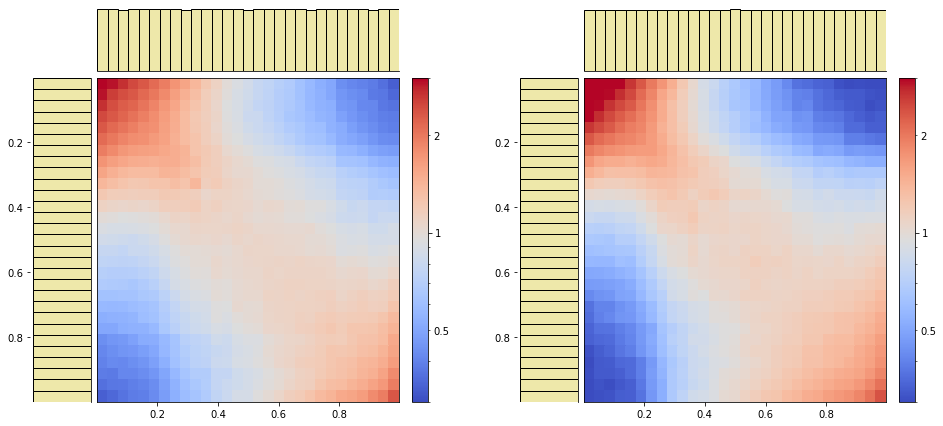

In [10]:
from cooltools import saddle

QUANTILE_BINNING = True

binedges = {}
digitized = {}
hist = {}
sums = {}
counts = {}
saddledata = {}

gs = plt.GridSpec(nrows=1, ncols=2)
fig = plt.figure(figsize=(16, 8))
histbins = 30

for i, cond in enumerate(['1',
                          '2']
):
    exp = pd.read_table(f'{pathDir}/{long_names[cond]}.mm10.250000.cis.expected')
    eig = pd.read_table(f'{pathDir}/{long_names[cond]}.mm10.250000.compcall.cis.vecs.tsv')

# Determine how to bin the range of the E1 signal
    if QUANTILE_BINNING:
        q_binedges = np.linspace(0.002, 0.998, histbins)
        binedges[cond] = saddle.quantile(eig['E1'], q_binedges)
    else:
        qlo, qhi = saddle.quantile(eig['E1'], [0.02, 0.98])  # trim outliers
        binedges[cond] = np.linspace(qlo, qhi, histbins)
# Digitize the signal into integers
    digitized[cond], hist[cond] = saddle.digitize_track(
        binedges[cond], 
        track=(eig, 'E1'))
# Construct a function that fetches and calculates observed/expected
    getmatrix = saddle.make_cis_obsexp_fetcher(clrs[cond], (exp, 'balanced.avg'))
    
# Build the saddle histogram
    sums[cond], counts[cond] = saddle.make_saddle(
        getmatrix, 
        binedges[cond],
        (digitized[cond], 'E1.d'), 
        contact_type='cis')
    saddledata[cond] = sums[cond] / counts[cond]
# Make the saddle plot
    g = saddle.saddleplot(
        q_binedges if QUANTILE_BINNING else binedges[cond],
        hist[cond],
        saddledata[cond], 
        color="palegoldenrod",
        heatmap_kws={'vmin': 0.3, 'vmax': 3}, 
        fig=fig, 
        subplot_spec=gs[i])

#plt.savefig("", bbox_inches='tight')


In [11]:
strength = {
    cond: saddle.saddle_strength(sums[cond], counts[cond]) 
        for cond in ['1',
                     '2']
}

/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/cooltools/saddle.py:562: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count


In [12]:
def saddle_strength_AB(S, C): 
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(0, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count #Don't need divide AB + BA by 2 since ratio and cancels out 
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(0, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios


/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'MEF-4OHT-dmso')

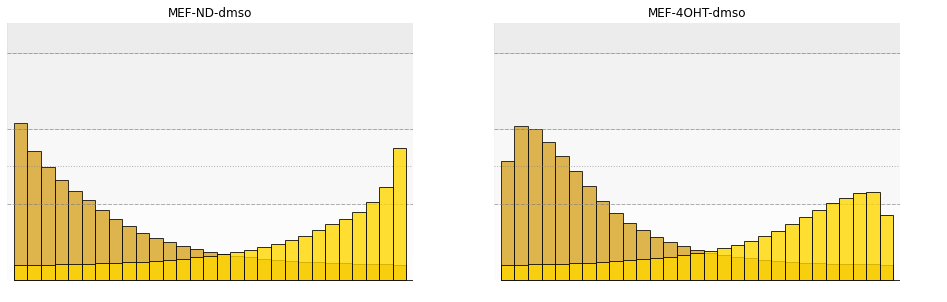

In [13]:
strengthAB = {
    cond: saddle_strength_AB(sums[cond], counts[cond]) 
        for cond in ['1',
                     '2']
}

#hist for A
y1=strengthAB['1']['A'][2:][::-1]
y1[np.isnan(y1)] = 0
y1 = np.insert(y1, 29,0)

y2=strengthAB['2']['A'][2:][::-1]
y2[np.isnan(y2)] = 0
y2 = np.insert(y2, 29,0)

#hist for B
z1=strengthAB['1']['B'][2:]
z1[np.isnan(z1)] = 0

z2=strengthAB['2']['B'][2:]
z2[np.isnan(z2)] = 0


#PLOTTING
gs = plt.GridSpec(nrows=1, ncols=2, width_ratios=[20] * len(conditions))
plt.figure(figsize=(16,5))

x = np.arange(histbins)

plt.subplot(gs[0])
plt.bar(x[:29], z1, color='goldenrod', alpha=0.8, width=1, edgecolor="k")
plt.bar(x[0:], y1, color='gold', alpha=0.8, width=1, edgecolor="k", zorder=10)
plt.axhline(5, c='grey', ls='--', lw=1, alpha=0.6)
plt.axhline(7.5, c='grey', ls=':', lw=1, alpha=0.6)
plt.axhline(10, c='grey', ls='--', lw=1, alpha=0.6)
plt.axhline(15, c='grey', ls='--', lw=1, alpha=0.6)
#plt.annotate(xy=(31,2.5), text="2.5")
plt.annotate(xy=(31,5), text="5",zorder=1)
plt.annotate(xy=(31,10), text="10", zorder=1)
plt.annotate(xy=(31,15), text="15", zorder=1)
plt.axhspan(0, 5, alpha=0.025, color='grey',zorder=1)
plt.axhspan(5, 10, alpha=0.05, color='grey',zorder=1)
plt.axhspan(10, 15, alpha=0.1, color='grey',zorder=1)
plt.axhspan(15, 20, alpha=0.15, color='grey',zorder=1)
plt.ylim((-1,17))
plt.xlim((-1,29))
#plt.xticks(color='w')
plt.gca().axison = False
plt.title('MEF-ND-dmso')

plt.subplot(gs[1])
plt.bar(x[:29], z2, color='goldenrod', alpha=0.8, width=1, edgecolor="k")
plt.bar(x[0:], y2, color='gold', alpha=0.8, width=1, edgecolor="k", zorder=10)
plt.axhline(5, c='grey', ls='--', lw=1, alpha=0.6)
plt.axhline(7.5, c='grey', ls=':', lw=1, alpha=0.6)
plt.axhline(10, c='grey', ls='--', lw=1, alpha=0.6)
plt.axhline(15, c='grey', ls='--', lw=1, alpha=0.6)
#plt.annotate(xy=(31,2.5), text="2.5")
plt.annotate(xy=(31,5), text="5",zorder=1)
plt.annotate(xy=(31,10), text="10", zorder=1)
plt.annotate(xy=(31,15), text="15", zorder=1)
plt.axhspan(0, 5, alpha=0.025, color='grey',zorder=1)
plt.axhspan(5, 10, alpha=0.05, color='grey',zorder=1)
plt.axhspan(10, 15, alpha=0.1, color='grey',zorder=1)
plt.axhspan(15, 20, alpha=0.15, color='grey',zorder=1)
plt.ylim((-1,17))
plt.xlim((-1,29))
plt.gca().axison = False
plt.title('MEF-4OHT-dmso')

#plt.savefig("*.pdf", bbox_inches='tight')


In [14]:
sB={}
for cond in conditions:
        sB0=strengthAB[cond]['B'][2:8]
        sB0[np.isnan(sB0)] = 0
        sB0=np.sum(sB0[:])/6
        sB[cond]=sB0
sB


{'1': 7.337197777468752, '2': 8.750949792933065}

In [15]:
sA={}
for cond in conditions:
        sA0=strengthAB[cond]['A'][2:8]
        sA0[np.isnan(sA0)] = 0
        sA0=np.sum(sA0[:])/6
        sA[cond]=sA0
sA


{'1': 5.352202593798331, '2': 5.14860732910453}

# compartment flips

In [16]:
eig1=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.250000.compcall.cis.vecs.tsv',sep='\t')
eig1=eig1[['chrom','start','end','E1']].dropna()
eig2=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.250000.compcall.cis.vecs.tsv',sep='\t')
eig2=eig2[['chrom','start','end','E1']].dropna()
eig1.head()


,chrom,start,end,E1
12,chr1,3000000,3250000,-0.890481
13,chr1,3250000,3500000,-1.184488
14,chr1,3500000,3750000,-1.221217
15,chr1,3750000,4000000,-1.080466
16,chr1,4000000,4250000,-1.012384


In [37]:
eig1_tota=eig1[(eig1['E1']>0)]
eig1_totb=eig1[(eig1['E1']<0)]
eig2_tota=eig2[(eig2['E1']>0)]
eig2_totb=eig2[(eig2['E1']<0)]
print(len(eig1), len(eig1_tota),len(eig1_totb))
#10245 5454 4791
print(len(eig2), len(eig2_tota),len(eig2_totb))
#10222 6100 4122


10245 5454 4791
10222 6100 4122


In [38]:
bins_250cis_dict = {'#A': [5454,6100], '#B': [4791,4122]}
bins_250cis = pd.DataFrame(data=bins_250cis_dict)
bins_250cis['tot']=bins_250cis['#A']+bins_250cis['#B']
bins_250cis['pA']=bins_250cis['#A']/bins_250cis['tot']
print(bins_250cis)


     #A    #B    tot        pA
0  5454  4791  10245  0.532357
1  6100  4122  10222  0.596752


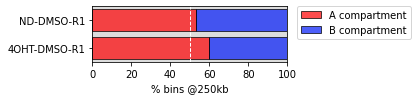

In [42]:
A=bins_250cis['pA']*100
B=(1-bins_250cis['pA'])*100
labels=['ND-DMSO-R1', '4OHT-DMSO-R1']
width=0.8

fig, ax = plt.subplots(figsize=(6,1.5))

ax.barh(labels, A, width, label='A compartment', edgecolor='k', color='#fe0002', alpha=0.7)
ax.barh(labels, B, width, label='B compartment', left=A, edgecolor='k', color='#021bf9', alpha=0.7)

ax.set_xlabel('% bins @250kb')
ax.invert_yaxis()  # labels read top-to-bottom
ax.legend(loc='upper left')
ax.set_xlim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.axvline(50, c='white', lw=1, ls='--')
ax.set_facecolor("gainsboro")

fig.tight_layout()
#plt.savefig('*.pdf', dpi=300, bbox_inches='tight')


In [43]:
#4OHTvND
eig1['eig2']=eig2['E1']
eig1_bta=eig1[(eig1['E1']<0) & (eig1['eig2']>0)]
eig1_atb=eig1[(eig1['E1']>0) & (eig1['eig2']<0)]
eig1_tota=eig1[(eig1['E1']>0)]
eig1_totb=eig1[(eig1['E1']<0)]

print(len(eig1_atb),len(eig1_bta),len(eig1_tota),len(eig1_totb))
#86 738 5454 4791


86 738 5454 4791


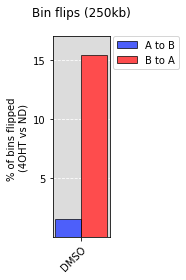

In [47]:
atb=[(86/5454)*100]
bta=[(738/4791)*100]
labels=['DMSO']

x = np.arange(len(labels))
width = 0.2 # the width of the bars

fig, ax = plt.subplots(figsize=(2.75,4), facecolor='white')
rects1 = ax.bar(x - width/2, atb, width, color='white', alpha=1, edgecolor='white',zorder=5)
rects2 = ax.bar(x + width/2, bta, width, color='white', alpha=1, edgecolor='white', zorder=5)

rects1 = ax.bar(x - width/2, atb, width, label='A to B', color='#021bf9', alpha=0.7, edgecolor='k',zorder=10)
rects2 = ax.bar(x + width/2, bta, width, label='B to A', color='#fe0002', alpha=0.7, edgecolor='k', zorder=10)


ax.set_ylabel('% of bins flipped \n(4OHT vs ND)')
ax.set_title('Bin flips (250kb)', pad=20)
ax.set_xticks(x)
ax.set_yticks([5,10,15])
ax.set_xticklabels(labels, rotation='45', ha='right', rotation_mode="anchor")
ax.legend()
ax.grid(which='major', axis='y', zorder=0, color='white',linestyle='--')
ax.set_facecolor("gainsboro")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim((0,17))

fig.tight_layout()
#plt.savefig('*.pdf', dpi = 300, bbox_inches='tight')


In [48]:
#comparing 1 and 2
eig1['eig2_E1']=eig2['E1']
#absolute differences
eig1['abs_d1_2'] = abs(eig1['E1']-eig1['eig2_E1'])
#adding direction of change
eig1.loc[(eig1['E1']<eig1['eig2_E1']), 'sign_d1_2'] = '+'
eig1.loc[(eig1['E1']>eig1['eig2_E1']), 'sign_d1_2'] = '-'
eig1['d1_2']=eig1['sign_d1_2']+eig1['abs_d1_2'].astype(str)
eig1['d1_2']=eig1['d1_2'].fillna(0)
eig1['d1_2']=eig1['d1_2'].astype(float)
eig1_a=eig1[eig1['E1']>0]
eig1_b=eig1[eig1['E1']<0]


In [49]:
eig1.loc[(eig1['eig2_E1']<0), 'colour'] = 'E1 <0 +4OHT'
eig1.loc[(eig1['eig2_E1']>0), 'colour'] = 'E1 >0 +4OHT'

diff_df = pd.DataFrame()
diff=(eig1['d1_2'])
diff = np.array(diff).ravel()
diff_df['E1change'] = diff.tolist()

E1_1=eig1['E1']
diff_df['E1']=E1_1.tolist()
colour=eig1['colour']
diff_df['colour']=colour.tolist()

bins=pd.IntervalIndex.from_tuples([(-2.2,-2),(-2, -1.8), (-1.8, -1.6), (-1.6, -1.4), (-1.4, -1.2), (-1.2, -1),(-1, -0.8), (-0.8, -0.6), (-0.6, -0.4), (-0.4, -0.2), (-0.2, 0), (0, 0.2),(0.2, 0.4),(0.4, 0.6),(0.6, 0.8), (0.8, 1),(1, 1.2),(1.2, 1.4),(1.4, 1.6),(1.6, 1.8), (1.8, 2)])
diff_df['bin'] = pd.cut(diff_df['E1'], bins)



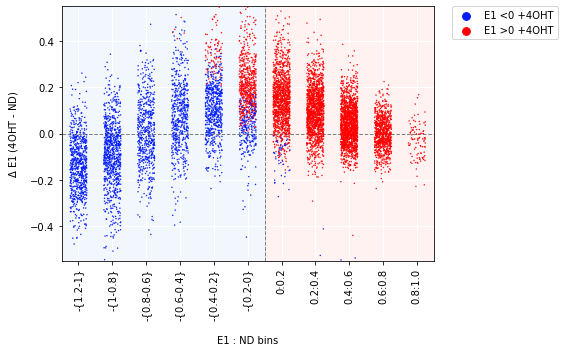

In [53]:
diff_df=diff_df[(diff_df['E1change']<=1.75) & (diff_df['E1change']>=-1.75)&(diff_df['E1']<=1.8)&(diff_df['E1']>=-1.8)]

green_diamond = dict(markerfacecolor='black', marker='o',markersize=1,markeredgecolor='none', linewidth=0, alpha=0)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

ax1=sns.stripplot(x='bin', y='E1change', data=diff_df,hue='colour',palette=['#021bf9','#fe0002'], size=1.5,alpha=0.9, linewidth=0,dodge=False,jitter=0.25, marker="o")
ax1.axhline(y=0, color='grey', linewidth=1.0, linestyle='--')
ax1.axvline(x=10.5, color='grey', linewidth=1.0, linestyle='--')
ax1.axvspan(0,10.5, color = "cornflowerblue", alpha=0.08,zorder=0)
ax1.axvspan(10.5,18, color = "tomato", alpha=0.08,zorder=0)
ax1.set(ylim=(-0.55,0.55))
ax1.set(xlim=(4.5,15.5))
ax1.set_xticklabels(labels= (' ', ' ', '-1.8:-1.6','-1.6:-1.4','-1.4:-1.2','-{1.2-1}','-{1-0.8}', '-{0.8-0.6}', '-{0.6-0.4}','-{0.4-0.2}','-{0.2-0}','0:0.2','0.2:0.4','0.4:0.6', '0.6:0.8', '0.8:1.0', '1.0:1.2', ' ', ' ', '1.6:1.8','2'),
                    rotation = 90,ha='center')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax1.set_xlabel('E1 : ND bins',labelpad=15)
ax1.set_ylabel(r'$\Delta$ E1 (4OHT - ND)',labelpad=10)
ax1.grid(color='white', linewidth=1)

fig.tight_layout()
#plt.savefig('*.pdf', dpi = 300, bbox_inches='tight')
